# A Totural on Binary Estimation 

In this notebook we are going to estimate weights (coefficients) of a linear regression model as binary values. Different scenarios with different methods such as least square, rounding, binary penalty term, and $L_1$ regularisation have been checked.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_validate
from scipy.stats import norm, multivariate_normal
from sklearn.linear_model import Lasso

# Data Generating

In [26]:
def DataGenerator(n_samples, n_features, weights=None, noise_variance=1, feature_mean = None, feature_cov = None, random_state=None):
    RNG = np.random.default_rng(seed=1)

    if weights is None:
       weights = np.squeeze(RNG.multivariate_normal(np.zeros(1), 2*np.eye(1), size=n_features))
    else:
        weights = weights
    
    # n_features = len(weights)

    feature_mean = np.zeros(n_features) if feature_mean is None else feature_mean
    feature_cov = np.eye(n_features) if feature_cov is None else feature_cov
    x = RNG.multivariate_normal(feature_mean, feature_cov, size=n_samples)
    # x = np.hstack((np.ones(shape=(n_samples, 1)), x))

    y = x.dot(weights) + RNG.normal(0, noise_variance, size=n_samples)
    return x, y, weights

# Squared Error

In [27]:
def squared_error(beta, x, y, d=None): 
    d = x.shape[1]
    beta = np.reshape(beta,(-1, d))
    return np.sum((beta@x.T-y)**2)/(2*len(x))

# Least Square Estimation

In [28]:
def leastsquare(x, y):
    return np.linalg.solve(x.T.dot(x), x.T.dot(y))

# Optimizer

In [29]:
def minimizer(lossfunction, alpha, x, y, n_features):   
    initial_beta = np.random.randint(2,size=(n_features))
    result = minimize(lossfunction, initial_beta, args=(alpha, x, y, n_features), method='Powell', options={'xtol':1e-8})
    optimized_beta = result.x
    return optimized_beta

# Sparsity: L1 Regularization Estimation

In [30]:
def L1_lossfunc(beta, alpha, x, y, n_features):
    return squared_error(beta, x, y, n_features) + alpha*np.sum(abs(np.reshape(beta,(-1,n_features))),axis=1)

# Sparsity: Binary Estimation

In [31]:
def binary_lossfunc(beta, alpha , x, y, n_features):
  pp = []
  beta = np.reshape(beta,(-1, n_features))
  for i in range((beta.shape)[0]):
    p = []
    for b in beta[i]:
      if b<=0.5:
        p.append(alpha*abs(b))
      else:
        p.append(alpha*abs(b-1))
    pp.append(np.sum(p))
  return squared_error(beta,x , y, n_features)+np.asarray(pp)

In [32]:
def binary_round(v):
    v = np.asarray(v)
    bv = []
    for x in v:
        if abs(x) < abs(x-1):
            x = 0
        elif abs(x-1) < abs(x):
            x = 1
        else:
            x = x
        bv.append(x)
    return bv

# Resampling

In [33]:
class Resampling:

    def __init__(self, reps, train_size, random_state=None):
        self.reps = reps
        self.train_size = train_size
        self.RNG = np.random.default_rng(random_state)

    def get_n_splits(self):
        return self.reps

    def split(self, x, y=None, groups=None):
        for _ in range(self.reps):
            train_idx = self.RNG.choice(np.arange(len(x)), size=self.train_size, replace=True)
            test_idx = np.setdiff1d(np.arange(len(x)), train_idx)
            np.random.shuffle(test_idx)
            yield train_idx, test_idx

# Scenario No. 1: A dataset with binary weights

In the first scenario a dataset with $n_features=10$ features and $n_samples$ sample has been considered. Dataset is generated over a normal distribution with $\mu=0$ and $\sigma^2=1$ or
$X \sim \mathcal{N}(\mu, \sigma^2)$.
The output is also generated based on a linear function including a noise term as follows 
\begin{align*}
Y&=X\beta+\epsilon \\
\epsilon &\sim \mathcal{N}(\mu, \sigma^2)
\end{align*}

$\beta$ is a vector of 0 and 1: $\beta_i \in \{1,0\}, \beta = \{\beta_i | i=1,..,n_{features}\}$

In [34]:
beta = np.array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1])
xb,yb, _ = DataGenerator(n_samples=50, n_features=len(beta), weights=beta)
xb_test, yb_test, _ = DataGenerator(n_samples=1000, n_features=len(beta), weights=beta)

First of all we check the effect of $\alpha$ on Lass and Binary penalties. In this regard, cross validation is applied to see this effect. In cross validation, KFold method from sklearn package has been used.

In [35]:
alpha_range = [0.001, 0.1, 0.5, 1, 1.5, 2, 3]

l1_mean_sse_valid_per_alpha, l1_beta_hat_mean_error_per_alpha, l1_beta_hat_std_error_per_alpha, l1_std_sse_valid_per_alpha, l1_mean_sse_train_per_alpha, l1_std_sse_train_per_alpha = [], [], [], [], [], []
binary_mean_sse_valid_per_alpha, binary_beta_hat_mean_error_per_alpha, binary_beta_hat_std_error_per_alpha, binary_std_sse_valid_per_alpha, binary_mean_sse_train_per_alpha, binary_std_sse_train_per_alpha= [], [], [], [], [],[]
n_folds = 25
kf = KFold(n_splits=n_folds, shuffle=True, random_state=529)
for a in alpha_range:
    l1_beta_hat_per_fold, l1_rounded_beta_hat_per_fold, l1_sse_train_per_fold, l1_sse_valid_per_fold = [], [], [], []
    binary_beta_hat_per_fold, binary_rounded_beta_hat_per_fold, binary_sse_train_per_fold, binary_sse_valid_per_fold = [], [], [], []
    for train_ind, val_ind in kf.split(xb,yb):

        # l1_beta_hat_per_fold.append(minimizer(L1_lossfunc, a, x[train_ind], y[train_ind], x.shape[1]))
        l1_beta_hat_per_fold.append(Lasso(alpha=a).fit(xb[train_ind], yb[train_ind]).coef_)
        l1_rounded_beta_hat_per_fold.append(binary_round(l1_beta_hat_per_fold[-1]))
        l1_sse_train_per_fold.append(squared_error(l1_rounded_beta_hat_per_fold[-1], xb[train_ind], yb[train_ind], xb.shape[1]))
        l1_sse_valid_per_fold.append(squared_error(l1_rounded_beta_hat_per_fold[-1], xb[val_ind], yb[val_ind], xb.shape[1]))
    
        binary_beta_hat_per_fold.append(minimizer(binary_lossfunc, a, xb[train_ind], yb[train_ind], xb.shape[1]))
        binary_rounded_beta_hat_per_fold.append(binary_round(binary_beta_hat_per_fold[-1]))
        binary_sse_valid_per_fold.append(squared_error(binary_rounded_beta_hat_per_fold[-1], xb[val_ind], yb[val_ind], xb.shape[1]))
        binary_sse_train_per_fold.append(squared_error(binary_rounded_beta_hat_per_fold[-1], xb[train_ind], yb[train_ind], xb.shape[1]))
        
    l1_mean_sse_valid_per_alpha.append(np.mean(l1_sse_valid_per_fold))
    l1_std_sse_valid_per_alpha.append(np.std(l1_sse_valid_per_fold))
    l1_mean_sse_train_per_alpha.append(np.mean(l1_sse_train_per_fold))
    l1_std_sse_train_per_alpha.append(np.std(l1_sse_train_per_fold))
    l1_beta_hat_mean_error_per_alpha.append(np.mean(np.sum((beta-l1_rounded_beta_hat_per_fold)**2, axis=1)))
    l1_beta_hat_std_error_per_alpha.append(np.std(np.sum((beta-l1_rounded_beta_hat_per_fold)**2, axis=1)))

    binary_mean_sse_valid_per_alpha.append(np.mean(binary_sse_valid_per_fold))
    binary_std_sse_valid_per_alpha.append(np.std(binary_sse_valid_per_fold))
    binary_mean_sse_train_per_alpha.append(np.mean(binary_sse_train_per_fold))
    binary_std_sse_train_per_alpha.append(np.std(binary_sse_train_per_fold))
    binary_beta_hat_mean_error_per_alpha.append(np.mean(np.sum((beta-binary_rounded_beta_hat_per_fold)**2, axis=1)))
    binary_beta_hat_std_error_per_alpha.append(np.std(np.sum((beta-binary_rounded_beta_hat_per_fold)**2, axis=1)))

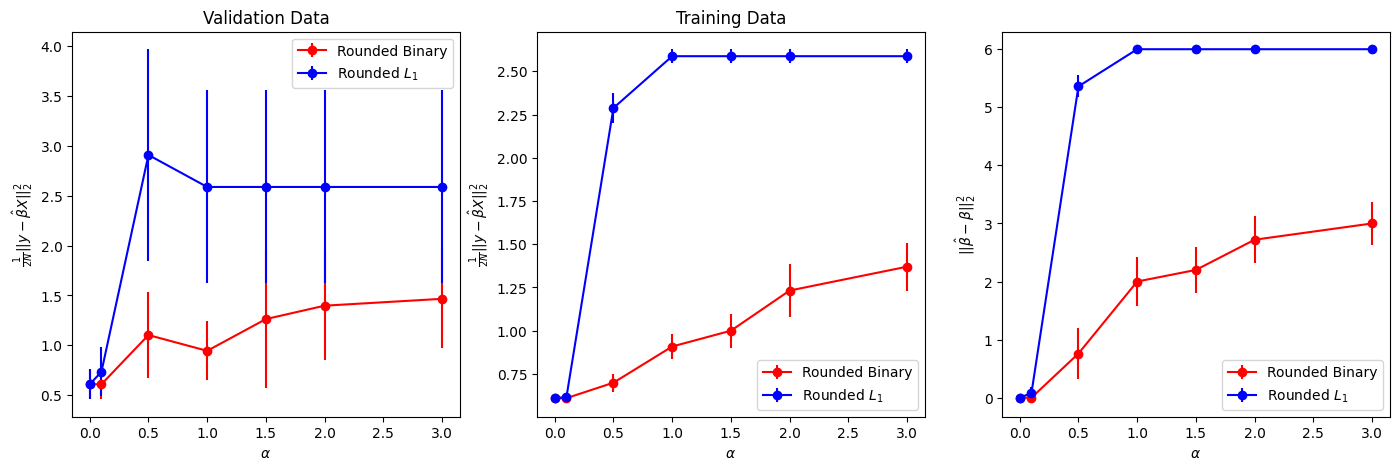

In [36]:
_, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].errorbar(alpha_range, binary_mean_sse_valid_per_alpha, yerr=np.array(binary_std_sse_valid_per_alpha)*1.96/(n_folds**0.5), marker='o', color='red', label='Rounded Binary')
axs[0].errorbar(alpha_range, l1_mean_sse_valid_per_alpha, yerr=np.array(l1_std_sse_valid_per_alpha)*1.96/(n_folds**0.5), marker='o', color='blue', label='Rounded $L_1$')
axs[0].set_xlabel('$\\alpha$')
axs[0].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta} X||_2^{2}$')
axs[0].set_title('Validation Data')
axs[0].legend()

axs[1].errorbar(alpha_range, binary_mean_sse_train_per_alpha, yerr=np.array(binary_std_sse_train_per_alpha)*1.96/(n_folds**0.5), marker='o', color='red', label='Rounded Binary')
axs[1].errorbar(alpha_range, l1_mean_sse_train_per_alpha, yerr=np.array(l1_std_sse_train_per_alpha)*1.96/(n_folds**0.5), marker='o', color='blue', label='Rounded $L_1$')
axs[1].set_xlabel('$\\alpha$')
axs[1].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta} X||_2^{2}$')
axs[1].set_title('Training Data')
axs[1].legend()

axs[2].errorbar(alpha_range, binary_beta_hat_mean_error_per_alpha, yerr=np.array(binary_beta_hat_std_error_per_alpha)*1.96/(n_folds**0.5), marker='o', color = 'red', label='Rounded Binary')
axs[2].errorbar(alpha_range, l1_beta_hat_mean_error_per_alpha, yerr=np.array(l1_beta_hat_std_error_per_alpha)*1.96/(n_folds**0.5), marker='o', color = 'blue', label='Rounded $L_1$')
axs[2].set_xlabel('$\\alpha$')
axs[2].set_ylabel('$||\\hat{\\beta}-\\beta||_{2}^{2}$')
# axs[2].set_title('With Rounding the Weights to 0 & 1')
axs[2].legend()

In [42]:
repetition = 100
alpha = 0.1

binary_beta_hat_mean_error = []
binary_beta_hat_std_error = []
l1_beta_hat_std_error, l1_beta_hat_mean_error , l1_mean_train_error_per_samplesize, l1_std_train_error_per_samplesize, l1_mean_test_error_per_samplesize, l1_std_test_error_per_samplesize =  [], [], [],[],[],[]
ls_beta_hat_mean_error, ls_beta_hat_std_error, ls_mean_train_error_per_samplesize,ls_std_train_error_per_samplesize, ls_mean_test_error_per_samplesize,ls_std_test_error_per_samplesize= [], [], [],[],[],[]
binary_beta_hat_std_error, binary_beta_hat_mean_error, binary_mean_train_error_per_samplesize, binary_std_train_error_per_samplesize, binary_mean_test_error_per_samplesize, binary_std_test_error_per_samplesize = [], [], [],[],[],[]
rls_beta_hat_mean_error, rls_beta_hat_std_error, rls_mean_train_error_per_samplesize, rls_std_train_error_per_samplesize, rls_mean_test_error_per_samplesize, rls_std_test_error_per_samplesize = [], [], [],[],[],[]

sample_size = np.linspace(0.3,1,30)
sample_size = np.round(len(xb)*np.array(sample_size)).astype(int)

for ss in sample_size:

    res = Resampling(repetition, train_size=ss, random_state=0)
    splitted_data = res.split(xb, yb)
    l1_beta_hat, l1_sse_train_error, l1_sse_test_error, rl1_beta_hat = [], [], [], []
    binary_beta_hat, binary_sse_train_error, binary_sse_test_error, rbinary_beta_hat = [], [], [], []
    ls_beta_hat, ls_sse_train_error, ls_sse_test_error = [], [], []
    rls_beta_hat, rls_sse_train_error, rls_sse_test_error = [], [], []
    

    for train_idx, _ in splitted_data:

        # l1_beta_hat.append(minimizer(L1_lossfunc, alpha, x[train_idx], y[train_idx], x.shape[1]))
        l1_beta_hat.append(Lasso(alpha=alpha).fit(xb[train_idx], yb[train_idx]).coef_)
        rl1_beta_hat.append(binary_round(l1_beta_hat[-1]))
        l1_sse_train_error.append(squared_error(rl1_beta_hat[-1], xb[train_idx], yb[train_idx], xb.shape[1]))
        l1_sse_test_error.append(squared_error(rl1_beta_hat[-1], xb_test, yb_test, xb_test.shape[1]))

        binary_beta_hat.append(minimizer(binary_lossfunc, alpha, xb[train_idx], yb[train_idx], xb.shape[1]))
        rbinary_beta_hat.append(binary_round(binary_beta_hat[-1]))
        binary_sse_train_error.append(squared_error(rbinary_beta_hat[-1], xb[train_idx], yb[train_idx], xb.shape[1]))
        binary_sse_test_error.append(squared_error(rbinary_beta_hat[-1], xb_test, yb_test, xb_test.shape[1]))

        ls_beta_hat.append(leastsquare(xb[train_idx], yb[train_idx]))
        ls_sse_train_error.append(squared_error(ls_beta_hat[-1], xb[train_idx], yb[train_idx], xb.shape[1]))
        ls_sse_test_error.append(squared_error(ls_beta_hat[-1], xb_test, yb_test, xb_test.shape[1]))
        rls_beta_hat.append(binary_round(ls_beta_hat[-1]))
        rls_sse_train_error.append(squared_error(rls_beta_hat[-1], xb[train_idx], yb[train_idx], xb.shape[1]))
        rls_sse_test_error.append(squared_error(rls_beta_hat[-1], xb_test, yb_test, xb_test.shape[1]))

        
    l1_beta_hat_mean_error.append(np.mean(np.sum((beta-rl1_beta_hat)**2, axis=1)))
    l1_beta_hat_std_error.append(np.std(np.sum((beta-rl1_beta_hat)**2, axis=1)))
    l1_mean_train_error_per_samplesize.append(np.mean(l1_sse_train_error))
    l1_std_train_error_per_samplesize.append(np.std(l1_sse_train_error))
    l1_mean_test_error_per_samplesize.append(np.mean(l1_sse_test_error))
    l1_std_test_error_per_samplesize.append(np.std(l1_sse_test_error))

    binary_beta_hat_mean_error.append(np.mean(np.sum((beta-rbinary_beta_hat)**2, axis=1)))
    binary_beta_hat_std_error.append(np.std(np.sum((beta-rbinary_beta_hat)**2, axis=1)))
    binary_mean_train_error_per_samplesize.append(np.mean(binary_sse_train_error))
    binary_std_train_error_per_samplesize.append(np.std(binary_sse_train_error))
    binary_mean_test_error_per_samplesize.append(np.mean(binary_sse_test_error))
    binary_std_test_error_per_samplesize.append(np.std(binary_sse_test_error))

    ls_beta_hat_mean_error.append(np.mean(np.sum((beta-ls_beta_hat)**2, axis=1)))
    ls_beta_hat_std_error.append(np.std(np.sum((beta-ls_beta_hat)**2, axis=1)))
    ls_mean_train_error_per_samplesize.append(np.mean(ls_sse_train_error))
    ls_std_train_error_per_samplesize.append(np.std(ls_sse_train_error))
    ls_mean_test_error_per_samplesize.append(np.mean(ls_sse_test_error))
    ls_std_test_error_per_samplesize.append(np.std(ls_sse_test_error))

    rls_beta_hat_mean_error.append(np.mean(np.sum((beta-rls_beta_hat)**2, axis=1)))
    rls_beta_hat_std_error.append(np.std(np.sum((beta-rls_beta_hat)**2, axis=1)))
    rls_mean_train_error_per_samplesize.append(np.mean(rls_sse_train_error))
    rls_std_train_error_per_samplesize.append(np.std(rls_sse_train_error))
    rls_mean_test_error_per_samplesize.append(np.mean(rls_sse_test_error))
    rls_std_test_error_per_samplesize.append(np.std(rls_sse_test_error))


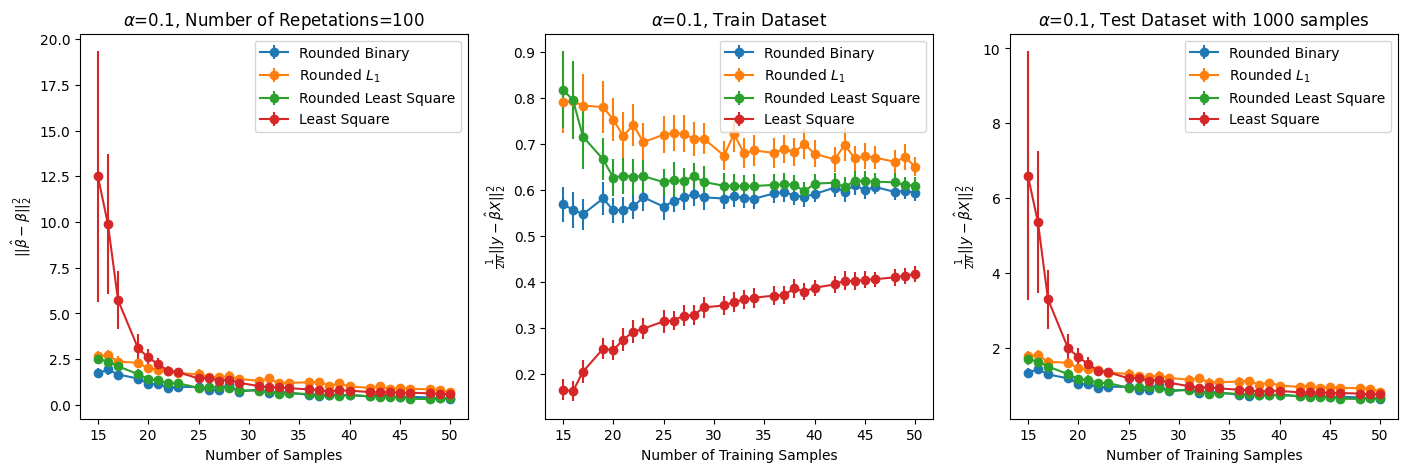

In [47]:
_, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].errorbar(sample_size, binary_beta_hat_mean_error, yerr=np.array(binary_beta_hat_std_error)*1.96/(repetition**0.5), marker='o', label='Rounded Binary')
axs[0].errorbar(sample_size, l1_beta_hat_mean_error, yerr=np.array(l1_beta_hat_std_error)*1.96/(repetition**0.5), marker='o',  label='Rounded $L_1$')
axs[0].errorbar(sample_size, rls_beta_hat_mean_error, yerr=np.array(rls_beta_hat_std_error)*1.96/(repetition**0.5), marker='o',  label='Rounded Least Square')
axs[0].errorbar(sample_size, ls_beta_hat_mean_error, yerr=np.array(ls_beta_hat_std_error)*1.96/(repetition**0.5), marker='o', label='Least Square')
axs[0].set_xlabel('Number of Samples')
axs[0].set_ylabel('$||\\hat{\\beta}-\\beta||_{2}^{2}$')
axs[0].set_title(f'$\\alpha$={alpha}, Number of Repetations={repetition}')
axs[0].legend()

axs[1].errorbar(sample_size, binary_mean_train_error_per_samplesize, yerr=np.array(binary_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Binary')
axs[1].errorbar(sample_size, l1_mean_train_error_per_samplesize, yerr=np.array(l1_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o',  label='Rounded $L_1$')
axs[1].errorbar(sample_size, rls_mean_train_error_per_samplesize, yerr=np.array(rls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
axs[1].errorbar(sample_size, ls_mean_train_error_per_samplesize, yerr=np.array(ls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o',  label='Least Square')
axs[1].set_xlabel('Number of Training Samples')
axs[1].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[1].set_title(f'$\\alpha$={alpha}, Train Dataset')
axs[1].legend()

axs[2].errorbar(sample_size, binary_mean_test_error_per_samplesize, yerr=np.array(binary_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Binary')
axs[2].errorbar(sample_size, l1_mean_test_error_per_samplesize, yerr=np.array(l1_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded $L_1$')
axs[2].errorbar(sample_size, rls_mean_test_error_per_samplesize, yerr=np.array(rls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
axs[2].errorbar(sample_size, ls_mean_test_error_per_samplesize, yerr=np.array(ls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o',  label='Least Square')
axs[2].set_xlabel('Number of Training Samples')
axs[2].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[2].set_title(f'$\\alpha$={alpha}, Test Dataset with 1000 samples')
axs[2].legend()

# Scenario No. 2: A dataset with non-binary weights (Rounded Least Square vs. Rounded Binary Penalty)

In this scenario, the database is generated same as before with $n_{features}=10$ from a normal distribution $X \sim \mathcal{N}(\mu_1=0, \sigma_1^2=1)$ but $\beta$ is a vector of non-binary values from $\beta \sim \mathcal{N}(\mu_2=0, \sigma_2^2=2)$. Now we are going to find the best binary approximation for $\beta$ that minimizes the loss function.

In [48]:
xnb, ynb, beta_nb = DataGenerator(n_samples=100, n_features=10)
xnb_test, ynb_test, _ = DataGenerator(n_samples=1000, weights=beta_nb, n_features=10)

In [ ]:
RNG = np.random.default_rng(seed=1)
repetition = 500
sample_size = np.linspace(0.2,1,30)
sample_size = np.round(len(xnb)*np.array(sample_size)).astype(int)

ls_beta_hat_mean_error_per_samplesize, ls_beta_hat_std_error_per_samplesize, ls_sse_train_error_per_samplesize, ls_sse_test_error_per_samplesize = [], [], [], []
rls_beta_hat_mean_error_per_samplesize, rls_beta_hat_std_error_per_samplesize, rls_sse_train_error_per_samplesize, rls_sse_test_error_per_samplesize = [], [], [], []
ls_std_train_error_per_samplesize, ls_std_test_error_per_samplesize = [], []
rls_std_test_error_per_samplesize, rls_std_train_error_per_samplesize = [], []
binary_sse_train_error_per_samplesize, binary_sse_test_error_per_samplesize, binary_std_train_error_per_samplesize, binary_std_test_error_per_samplesize = [], [], [], []

for ss in sample_size:
    print(ss)
    ls_beta_hat = []
    rls_beta_hat = []
    binary_beta_hat = []
    ls_sse_train_error = []
    ls_sse_test_error = []
    rls_sse_train_error = []
    rls_sse_test_error = []
    binary_sse_train_error = []
    binary_sse_test_error = []

    res = Resampling(repetition, ss, random_state=0)
    for train_id, _ in res.split(xnb):
        ls_beta_hat.append(leastsquare(xnb[train_id], ynb[train_id]))
        ls_sse_train_error.append(squared_error(ls_beta_hat[-1], xnb[train_id], ynb[train_id], xnb.shape[1]))
        ls_sse_test_error.append(squared_error(ls_beta_hat[-1], xnb_test, ynb_test, xnb_test.shape[1]))

        rls_beta_hat.append(binary_round(ls_beta_hat[-1]))
        rls_sse_train_error.append(squared_error(rls_beta_hat[-1], xnb[train_id], ynb[train_id], xnb.shape[1]))
        rls_sse_test_error.append(squared_error(rls_beta_hat[-1], xnb_test, ynb_test, xnb_test.shape[1]))

        binary_beta_hat.append(binary_round(minimizer(binary_lossfunc, alpha=0.1, x=xnb[train_id], y=ynb[train_id], n_features=xnb.shape[1])))
        binary_sse_train_error.append(squared_error(binary_beta_hat[-1], xnb[train_id], ynb[train_id], xnb.shape[1]))
        binary_sse_test_error.append(squared_error(binary_beta_hat[-1], xnb_test, ynb_test, xnb_test.shape[1]))

    ls_sse_train_error_per_samplesize.append(np.mean(ls_sse_train_error))
    ls_std_train_error_per_samplesize.append(np.std(ls_sse_train_error))
    ls_sse_test_error_per_samplesize.append(np.mean(ls_sse_test_error))
    ls_std_test_error_per_samplesize.append(np.std(ls_sse_test_error))

    rls_sse_train_error_per_samplesize.append(np.mean(rls_sse_train_error))
    rls_std_train_error_per_samplesize.append(np.std(rls_sse_train_error))
    rls_sse_test_error_per_samplesize.append(np.mean(rls_sse_test_error))
    rls_std_test_error_per_samplesize.append(np.std(rls_sse_test_error))

    binary_sse_train_error_per_samplesize.append(np.mean(binary_sse_train_error))
    binary_std_train_error_per_samplesize.append(np.std(binary_sse_train_error))
    binary_sse_test_error_per_samplesize.append(np.mean(binary_sse_test_error))
    binary_std_test_error_per_samplesize.append(np.std(binary_sse_test_error))


Text(0.5, 0.98, '$\\beta_i \\in \\mathcal{N}(0, 2)$')

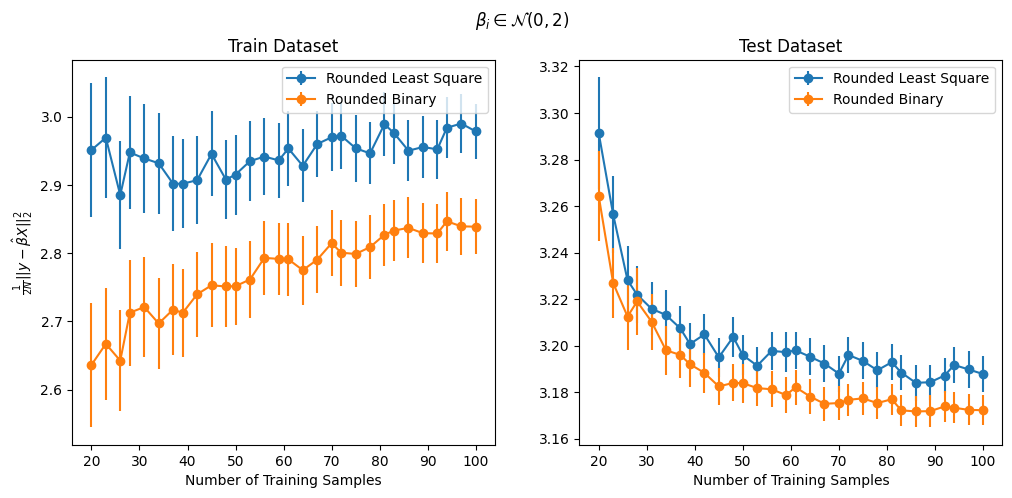

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# axs[0].errorbar(sample_size, ls_sse_train_error_per_samplesize, yerr=np.array(ls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Least Square')
axs[0].errorbar(sample_size, rls_sse_train_error_per_samplesize, yerr=np.array(rls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
axs[0].errorbar(sample_size, binary_sse_train_error_per_samplesize, yerr=np.array(binary_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Binary')
axs[0].set_xlabel('Number of Training Samples')
axs[0].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[0].set_title(f'Train Dataset')
axs[0].legend()

# axs[1].errorbar(sample_size, ls_sse_test_error_per_samplesize, yerr=np.array(ls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o',  label='Least Square')
axs[1].errorbar(sample_size, rls_sse_test_error_per_samplesize, yerr=np.array(rls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
axs[1].errorbar(sample_size, binary_sse_test_error_per_samplesize, yerr=np.array(binary_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Binary')
axs[1].set_xlabel('Number of Training Samples')
# axs[1].set_ylabel('SSE')
axs[1].set_title(f'Test Dataset')
axs[1].legend()

fig.suptitle('$\\beta_i \in \\mathcal{N}(0, 2)$')

# Scenario No. 3

In this scenario the weights vector is considered as $\beta = [0.5, 0.5, 0]$. Also the features are not independent from each other and thery are defined as follows

\begin{align*}
X&=[x_1, x_2, x_3]\\
x_3&=x_1 + x_2
\end{align*}

In [51]:
beta = np.array([0.5, 0.5, 0])
x, y, _ = DataGenerator(n_samples=100, weights=beta , n_features=3)
x_test, y_test, _ = DataGenerator(n_samples=1000, weights=beta, n_features=3)

In [ ]:
RNG = np.random.default_rng(seed=1)
repetition = 500
sample_size = np.linspace(0.2,1,35)
sample_size = np.round(len(x)*np.array(sample_size)).astype(int)

ls_sse_train_error_per_samplesize, ls_sse_test_error_per_samplesize = [], []
rls_sse_train_error_per_samplesize, rls_sse_test_error_per_samplesize = [], []
ls_std_train_error_per_samplesize, ls_std_test_error_per_samplesize = [], []
rls_std_test_error_per_samplesize, rls_std_train_error_per_samplesize = [], []
binary_sse_train_error_per_samplesize, binary_sse_test_error_per_samplesize, binary_std_train_error_per_samplesize, binary_std_test_error_per_samplesize = [], [], [], []

rls_beta_hat_mean_error_110, rls_beta_hat_mean_error_001, binary_beta_hat_mean_error_110, binary_beta_hat_mean_error_001 = [],[],[],[]
rls_beta_hat_std_error_110, rls_beta_hat_std_error_001, binary_beta_hat_std_error_110, binary_beta_hat_std_error_001 = [],[],[],[] 
binary_hat_vote, rls_hat_vote = [],[]

for ss in sample_size:
    print(ss)
    ls_beta_hat = []
    rls_beta_hat = []
    binary_beta_hat = []
    ls_sse_train_error = []
    ls_sse_test_error = []
    rls_sse_train_error = []
    rls_sse_test_error = []
    binary_sse_train_error = []
    binary_sse_test_error = []

    res = Resampling(repetition, ss, random_state=0)
    for train_id, _ in res.split(xnb):
        
        ls_beta_hat.append(leastsquare(x[train_id], ynb[train_id]))
        ls_sse_train_error.append(squared_error(ls_beta_hat[-1], x[train_id], y[train_id], x.shape[1]))
        ls_sse_test_error.append(squared_error(ls_beta_hat[-1], x_test, y_test, x.shape[1]))

        rls_beta_hat.append(binary_round(ls_beta_hat[-1]))
        rls_sse_train_error.append(squared_error(rls_beta_hat[-1], x[train_id], y[train_id], x.shape[1]))
        rls_sse_test_error.append(squared_error(rls_beta_hat[-1], x_test, y_test, x.shape[1]))

        binary_beta_hat.append(binary_round(minimizer(binary_lossfunc, alpha=0.1, x=x[train_id], y=y[train_id], n_features=x.shape[1])))
        binary_sse_train_error.append(squared_error(binary_beta_hat[-1], x[train_id], y[train_id], x.shape[1]))
        binary_sse_test_error.append(squared_error(binary_beta_hat[-1], x_test, y_test, x.shape[1]))

    ls_sse_train_error_per_samplesize.append(np.mean(ls_sse_train_error))
    ls_std_train_error_per_samplesize.append(np.std(ls_sse_train_error))
    ls_sse_test_error_per_samplesize.append(np.mean(ls_sse_test_error))
    ls_std_test_error_per_samplesize.append(np.std(ls_sse_test_error))

    rls_sse_train_error_per_samplesize.append(np.mean(rls_sse_train_error))
    rls_std_train_error_per_samplesize.append(np.std(rls_sse_train_error))
    rls_sse_test_error_per_samplesize.append(np.mean(rls_sse_test_error))
    rls_std_test_error_per_samplesize.append(np.std(rls_sse_test_error))

    binary_sse_train_error_per_samplesize.append(np.mean(binary_sse_train_error))
    binary_std_train_error_per_samplesize.append(np.std(binary_sse_train_error))
    binary_sse_test_error_per_samplesize.append(np.mean(binary_sse_test_error))
    binary_std_test_error_per_samplesize.append(np.std(binary_sse_test_error))

    rls_beta_hat_mean_error_110.append(np.mean(np.sum((np.array([1,1,0])-rls_beta_hat)**2, axis=1)))
    rls_beta_hat_mean_error_001.append(np.mean(np.sum((np.array([0,0,1])-rls_beta_hat)**2, axis=1)))
    binary_beta_hat_mean_error_110.append(np.mean(np.sum((np.array([1,1,0])-binary_beta_hat)**2, axis=1)))
    binary_beta_hat_mean_error_001.append(np.mean(np.sum((np.array([0,0,1])-binary_beta_hat)**2, axis=1)))

    rls_beta_hat_std_error_110.append(np.std(np.sum((np.array([1,1,0])-rls_beta_hat)**2, axis=1)))
    rls_beta_hat_std_error_001.append(np.std(np.sum((np.array([0,0,1])-rls_beta_hat)**2, axis=1)))
    binary_beta_hat_std_error_110.append(np.std(np.sum((np.array([1,1,0])-binary_beta_hat)**2, axis=1)))
    binary_beta_hat_std_error_001.append(np.std(np.sum((np.array([0,0,1])-binary_beta_hat)**2, axis=1)))

    binary_hat_vote.append(np.mean(binary_beta_hat, axis=0))
    rls_hat_vote.append(np.mean(rls_beta_hat, axis=0))


In [53]:
print(f'Rounded Least Square weights on average: {np.asarray(rls_hat_vote).mean(axis=0)}')
print(f'Binary weights on average: {np.asarray(binary_hat_vote).mean(axis=0)}')

Rounded Least Square weights on average: [0.39205714 0.13034286 0.04085714]
Binary weights on average: [0.5612     0.69988571 0.00285714]


Text(0.5, 0.98, '$\\beta = [0.5, 0.5, 0]$')

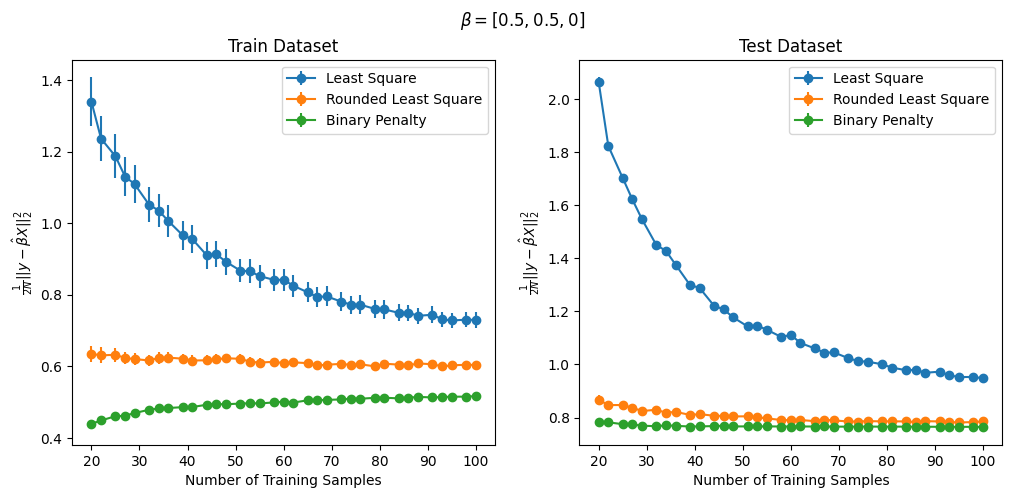

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].errorbar(sample_size, ls_sse_train_error_per_samplesize, yerr=np.array(ls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Least Square')
axs[0].errorbar(sample_size, rls_sse_train_error_per_samplesize, yerr=np.array(rls_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
axs[0].errorbar(sample_size, binary_sse_train_error_per_samplesize, yerr=np.array(binary_std_train_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Binary Penalty')
axs[0].set_xlabel('Number of Training Samples')
axs[0].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[0].set_title(f'Train Dataset')
axs[0].legend()

axs[1].errorbar(sample_size, ls_sse_test_error_per_samplesize, yerr=np.array(rls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o',  label='Least Square')
axs[1].errorbar(sample_size, rls_sse_test_error_per_samplesize, yerr=np.array(rls_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
axs[1].errorbar(sample_size, binary_sse_test_error_per_samplesize, yerr=np.array(binary_std_test_error_per_samplesize)*1.96/(repetition**0.5), marker='o', label='Binary Penalty')
axs[1].set_xlabel('Number of Training Samples')
axs[1].set_ylabel('$\\frac{1}{2N}||y-\\hat{\\beta}X||_{2}^{2}$')
axs[1].set_title(f'Test Dataset')
axs[1].legend()

fig.suptitle('$\\beta = [0.5, 0.5, 0]$')

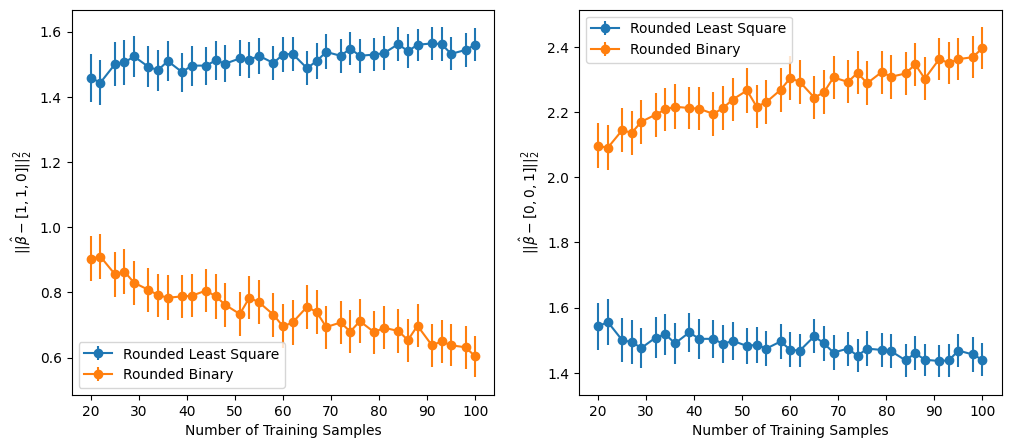

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].errorbar(sample_size, rls_beta_hat_mean_error_110, yerr=np.array(rls_beta_hat_std_error_110)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
axs[0].errorbar(sample_size, binary_beta_hat_mean_error_110, yerr=np.array(binary_beta_hat_std_error_110)*1.96/(repetition**0.5), marker='o', label='Rounded Binary')
axs[0].set_xlabel('Number of Training Samples')
axs[0].set_ylabel('$||\\hat{\\beta}-[1,1,0]||_{2}^{2}$')
axs[0].legend()

axs[1].errorbar(sample_size, rls_beta_hat_mean_error_001, yerr=np.array(rls_beta_hat_std_error_001)*1.96/(repetition**0.5), marker='o', label='Rounded Least Square')
axs[1].errorbar(sample_size, binary_beta_hat_mean_error_001, yerr=np.array(binary_beta_hat_std_error_001)*1.96/(repetition**0.5), marker='o', label='Rounded Binary')
axs[1].set_xlabel('Number of Training Samples')
axs[1].set_ylabel('$||\\hat{\\beta}-[0,0,1]||_{2}^{2}$')
axs[1].legend()